In [1]:
## 論文実装


In [2]:
import sys
import math
from heapq import *
from collections import defaultdict
import random
import networkx as nx
import matplotlib.pyplot as plt
from typing import List
sys.setrecursionlimit(10**7)

---
### グラフの作成

In [3]:
n = 10

# 隣接リストの作成
to = [[] for _ in range(n*n)]
for i in range(n*n):
    if (i+1) % n != 0:
        to[i].append(i+1)
    if i % n != 0:
        to[i].append(i-1)
    if i+n < n*n:
        to[i].append(i+n)
    if i-n >= 0:
        to[i].append(i-n)

In [4]:
# 通過不可能領域の生成
def generate_obstruction() -> List:
    """
    通過不可能領域は矩形とする。
    10×10
    """
    area_1 = [12, 13, 22, 23, 32, 33]
    area_2 = [65, 66, 67, 75, 76, 77]
    obs_area_list = area_1 + area_2

    obs_area_dict = defaultdict(int)
    for e in obs_area_list:
        obs_area_dict[e] = 1

    return obs_area_list, obs_area_dict


In [5]:
# グラフの可視化
def vis_gridpath(n, path_nodes, obs_nodes=None):
    # n×n の格子グラフを作成
    G = nx.grid_2d_graph(n, n)
    mapping = {(i, j): i*n + j for i, j in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    pos = {i * n + j: (j, -i) for i in range(n) for j in range(n)}
    path_edges = list(zip(path_nodes[:-1], path_nodes[1:]))

    # 描画
    plt.figure(figsize=(6,6))

    # 通常ノード・エッジ
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos)

    # 障害物エリアの描画
    if obs_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=obs_nodes, node_color='black', node_size=500)
        labels = {n: n for n in obs_nodes}
        nx.draw_networkx_labels(
            G, pos,
            labels=labels,
            font_color='white',
        )

    # 経路部分を強調（色を変える）
    nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='orange')
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.axis('off')
    plt.show()

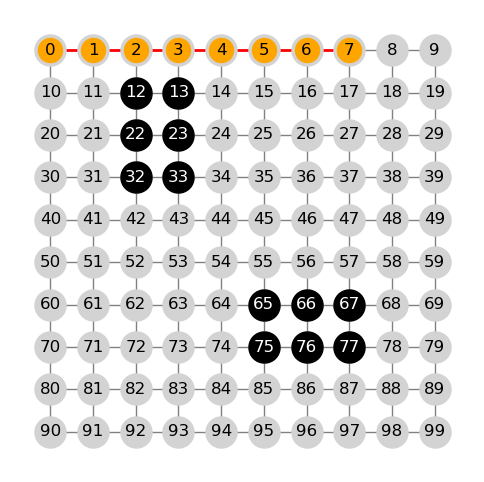

In [6]:
obs_nodes_list, obs_nodes_dict = generate_obstruction()

n = 10
path_nodes = [0, 1, 2, 3, 4, 5, 6, 7]
vis_gridpath(n, path_nodes, obs_nodes_list)

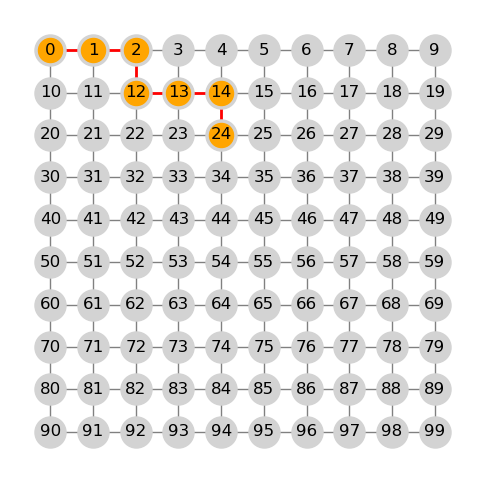

In [7]:
n = 10
path_nodes = [0, 1, 2, 12, 13, 14, 24]
vis_gridpath(n, path_nodes)

---
## 論文実装
https://unige.org/volume-74-issue-s1-2024/research-on-automatic-pcb-routing-strategy-based-on-ant-colony-algorithm/

Research on Automatic PCB Routing Strategy Based on Ant Colony Algorithm


In [8]:
n = 10
path_1 = [0, 10, 11, 21, 31, 41, 42, 52, 62, 63, 64, 65, 66, 76, 86, 87, 88, 89, 99]
path_2 = [10, 0, 1, 2, 3, 13, 23, 33, 43, 53, 63, 64, 65, 66, 76, 86, 87, 88, 89]
path_3 = [20, 21, 22, 12, 13, 23, 24, 25, 26, 27, 28, 38, 39, 49, 48, 58, 59, 69, 79]


path_nodes = [0, 1, 2, 12, 13, 14, 24]

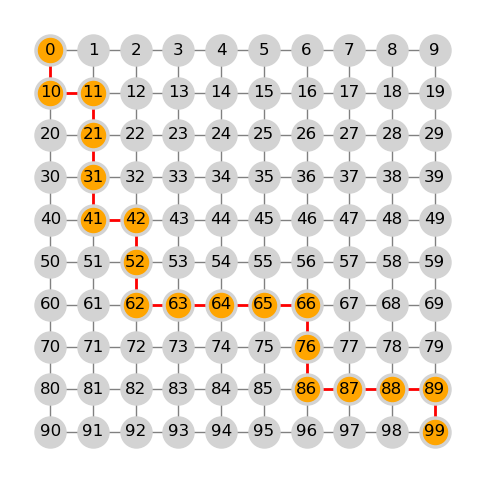

In [9]:
vis_gridpath(n, path_1)

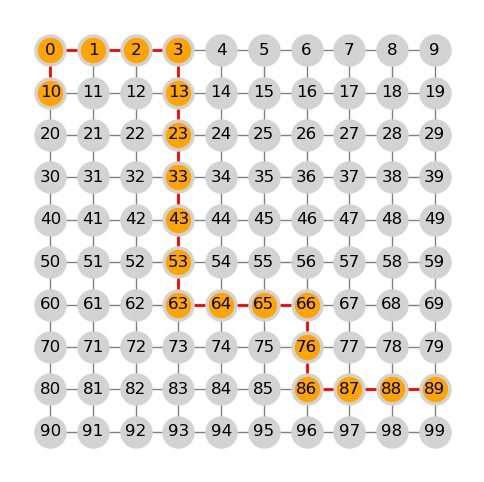

In [10]:
vis_gridpath(n, path_2)

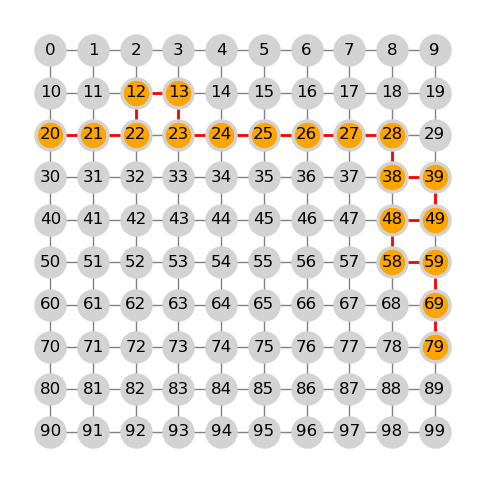

In [11]:
vis_gridpath(n, path_3)

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from collections import deque

In [13]:
# ------------------------
# 基本設定
# ------------------------
n = 10  # グリッドサイズ n×n
iterations = 100  # ACO繰り返し数
# iterations = 1000  # ACO繰り返し数
Q = 100.0  # フェロモン更新定数
rho = 0.5  # フェロモン蒸発率
alpha = 1.0  # フェロモンの影響
beta = 2.0   # ヒューリスティックの影響

In [14]:
# ------------------------
# 隣接リストでグラフ構築
# ------------------------
to = [[] for _ in range(n * n)]
for i in range(n * n):
    if (i + 1) % n != 0:
        to[i].append(i + 1)
    if i % n != 0:
        to[i].append(i - 1)
    if i + n < n * n:
        to[i].append(i + n)
    if i - n >= 0:
        to[i].append(i - n)

pheromone = np.ones((n * n, n * n))  # 初期フェロモン

In [15]:
# ------------------------
# BFSで最短経路（初期）
# ------------------------
def bfs_shortest_path(start, goal):
    visited = [False] * (n * n)
    prev = [-1] * (n * n)
    queue = deque([start])
    visited[start] = True
    while queue:
        v = queue.popleft()
        if v == goal:
            break
        for u in to[v]:
            if not visited[u]:
                visited[u] = True
                prev[u] = v
                queue.append(u)
    path = []
    cur = goal
    while cur != -1:
        path.append(cur)
        cur = prev[cur]
    path.reverse()
    return path

In [16]:
# ------------------------
# ACOによる等長配線補正
# ------------------------
def aco_equal_length(start, goal, target_length):
    best_path = []
    best_error = float('inf')
    for _ in range(iterations):
        path = [start]
        visited = set(path)
        current = start

        for _ in range(target_length * 2):  # 余裕もって探索
            neighbors = [v for v in to[current] if v not in visited]
            if not neighbors:
                break
            scores = []
            for v in neighbors:
                tau = pheromone[current][v] ** alpha
                eta = (1.0) ** beta  # ヒューリスティック（距離一定なので定数）
                scores.append((tau * eta, v))
            if not scores:
                break
            total = sum(score for score, _ in scores)
            r = random.random()
            acc = 0
            for score, v in scores:
                acc += score / total
                if r <= acc:
                    next_node = v
                    break
            path.append(next_node)
            visited.add(next_node)
            current = next_node
            if current == goal:
                break
        if path[-1] != goal:
            continue
        error = abs(len(path) - target_length)
        if error < best_error:
            best_path = path[:]
            best_error = error
        # フェロモン更新
        for u, v in zip(path[:-1], path[1:]):
            pheromone[u][v] = (1 - rho) * pheromone[u][v] + Q / (1 + error)
    return best_path

In [17]:
# # ------------------------
# # 可視化関数
# # ------------------------
# def vis_gridpath(n, path_nodes, obs_nodes=None):
#     G = nx.grid_2d_graph(n, n)
#     mapping = {(i, j): i * n + j for i, j in G.nodes()}
#     G = nx.relabel_nodes(G, mapping)
#     pos = {i * n + j: (j, -i) for i in range(n) for j in range(n)}
#     path_edges = list(zip(path_nodes[:-1], path_nodes[1:]))

#     plt.figure(figsize=(6, 6))
#     nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=500)
#     nx.draw_networkx_edges(G, pos, edge_color='gray')
#     nx.draw_networkx_labels(G, pos)

#     if obs_nodes:
#         nx.draw_networkx_nodes(G, pos, nodelist=obs_nodes, node_color='black', node_size=500)
#         labels = {n: n for n in obs_nodes}
#         nx.draw_networkx_labels(G, pos, labels=labels, font_color='white')

#     nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='orange')
#     nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
#     plt.axis('off')
#     plt.show()

In [18]:
# ---------------------------------------------------
# 可視化関数(一つのグラフに複数本の経路が引けるようにした)
# ---------------------------------------------------
def vis_gridpath(n, paths, obs_nodes=None):
    """
    グリッドグラフ上に経路を描画する。

    Args:
        n (int):
        paths (List[List[int]]): 経路の集合。一つの経路はnodeのwaypointから構成される。
    Returns:
        None
    """
    node_colors = ['orange', 'cyan', 'greenyellow', 'violet']
    edge_colors = ['red', 'blue', 'green', 'blueviolet']
    G = nx.grid_2d_graph(n, n)
    mapping = {(i, j): i * n + j for i, j in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    pos = {i * n + j: (j, -i) for i in range(n) for j in range(n)}
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos)

    if obs_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=obs_nodes, node_color='black', node_size=500)
        labels = {n: n for n in obs_nodes}
        nx.draw_networkx_labels(G, pos, labels=labels, font_color='white')

    for (i, path) in enumerate(paths):
        edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='orange')
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)

        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color=node_colors[i % len(paths)])
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors[i % len(paths)], width=2)

    plt.axis('off')
    plt.show()

In [19]:
def make_random_start_goal():
    import random

    # 0から99までの整数から重複なしで6つ選ぶ
    nums = random.sample(range(100), 6)

    # a1,...,a6 に展開
    a1, a2, a3, a4, a5, a6 = nums

    # 指定の形にまとめる
    pairs = [(a1, a2), (a3, a4), (a5, a6)]

    print("選ばれた数:", nums)
    print("結果:", pairs)

    return pairs

# nets = make_random_start_goal()

In [20]:
# ------------------------
# 実行例：複数ネットを等長配線
# ------------------------
import time 
start = time.time() # 処理時間計測開始

# nets = [(0, 99), (10, 89), (20, 79)]
# nets = [(0, 35), (14, 74), (83, 67)]
# nets = [(42, 7), (89, 13), (66, 21)]
nets = [(48, 63), (94, 58), (0, 51)]

initial_paths = [bfs_shortest_path(s, g) for s, g in nets]
max_len = max(len(p) for p in initial_paths)
final_paths = [aco_equal_length(s, g, max_len) for s, g in nets]


end = time.time() # 処理時間計測終了
print("処理時間:", end - start, "秒")


処理時間: 0.008245229721069336 秒


len(path) = 10


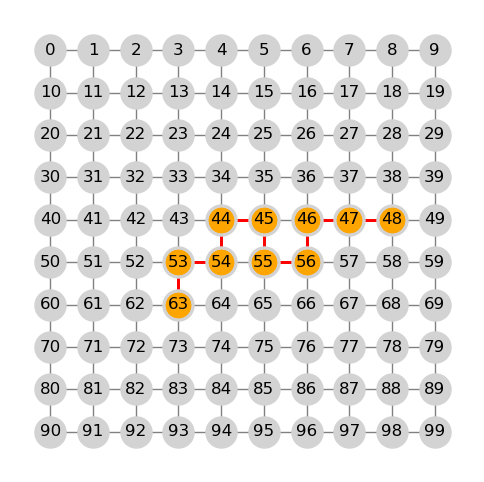

len(path) = 9


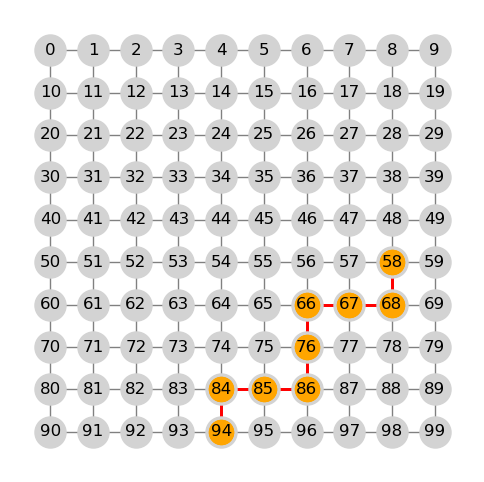

len(path) = 9


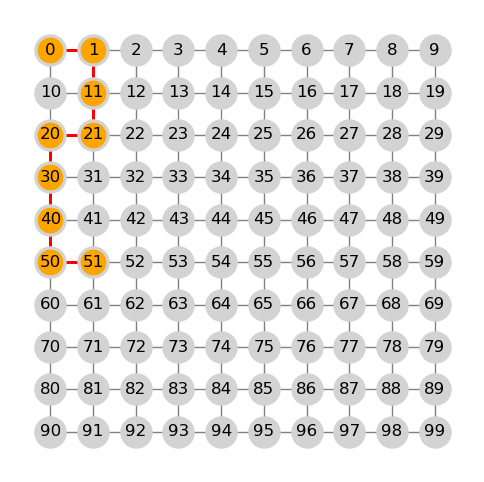

In [21]:
# # 可視化
# for path in final_paths:
#     print("len(path) =", len(path))
#     vis_gridpath(n, path)

# 可視化
for path in final_paths:
    print("len(path) =", len(path))
    vis_gridpath(n, [path])

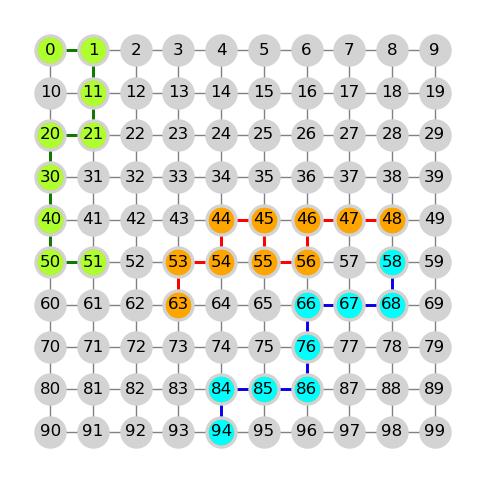

In [22]:
# まとめて描画
vis_gridpath(n, final_paths)

In [23]:
def vis_pheromone(n, pheromone, to):
    # 格子グラフ作成
    G = nx.grid_2d_graph(n, n)
    mapping = {(i, j): i * n + j for i, j in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    pos = {i * n + j: (j, -i) for i in range(n) for j in range(n)}

    # エッジごとのフェロモン値を抽出（重複なし、無向辺扱い）
    pheromone_dict = {}
    for u in range(n * n):
        for v in to[u]:
            key = tuple(sorted((u, v)))
            pheromone_dict[key] = pheromone[u][v]

    # 正規化して線の太さに変換
    pheromone_vals = list(pheromone_dict.values())
    min_p, max_p = min(pheromone_vals), max(pheromone_vals)
    def scale(tau):
        return 0.5 + 4.5 * (tau - min_p) / (max_p - min_p + 1e-6)

    edge_widths = [scale(pheromone_dict[tuple(sorted((u, v)))]) for u, v in G.edges()]
    edge_colors = ['red' if pheromone_dict[tuple(sorted((u, v)))] > min_p else 'gray' for u, v in G.edges()]

    # 描画
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=500)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)
    plt.title("Pheromone Visualization (Edge Width = Intensity)")
    plt.axis('off')
    plt.show()

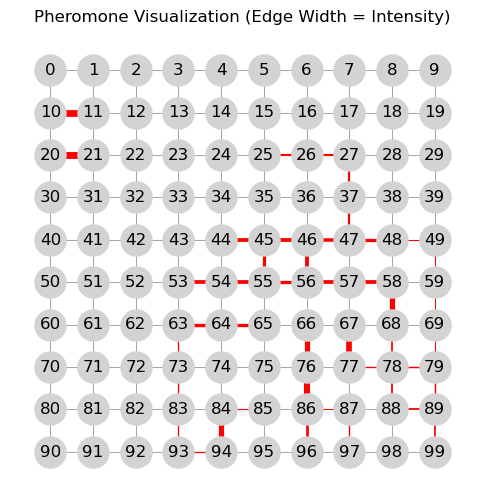

In [24]:
vis_pheromone(n, pheromone, to)

In [25]:
pheromone.shape

(100, 100)